In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from wrf_helpers import get_zgrid_meanProfiles as zgrid
from pandas import to_datetime

In [2]:
save=True
savename='profiles_SSandFullDev'

In [3]:
T0 = -5 # K
slope = 3*np.pi/180. # rad
Tref = 308 # K
lapse = 0.015 # K/m
Km = 0.02 # m^2 / s
Kh = 0.04 # m^2 / s
g = 9.8 # m / s^2

In [4]:
path = "../WRFV3/LES3"
file= "wrfout_d01_2014-03-21_12:00:00"

ds = xr.open_dataset(path+'/'+file)#+'.nc')
ds

<xarray.Dataset>
Dimensions:                (Time: 121, south_north: 149, west_east: 399,
                            bottom_top: 68, bottom_top_stag: 69,
                            soil_layers_stag: 4, west_east_stag: 400,
                            south_north_stag: 150)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag
Data variables: (12/153)
    Times                  (Time) |S19 ...
    LU_INDEX               (Time, south_north, west_east) float32 ...
    ZNU                    (Time, bottom_top) float32 ...
    ZNW                    (Time, bottom_top_stag) float32 ...
    ZS                     (Time, soil_layers_stag) float32 ...
    DZS                    (Time, soil_layers_stag) float32 ...
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 ...
    PC                     (Time, south_north, west_east) float32 ...
    LANDMASK               (Time, south_north, west_east) float32 ...
    LAKEMASK               (Time, south_north, west_east) float32 ...
    SST                    (Time, south_north, west_east) float32 ...
    SST_INPUT              (Time, south_north, west_east) float32 ...
Attributes: (12/119)
    TITLE:                            OUTPUT FROM WRF V3.9.1.1 MODEL
    START_DATE:                      2014-03-21_12:00:00
    SIMULATION_START_DATE:           2014-03-21_12:00:00
    WEST-EAST_GRID_DIMENSION:        400
    SOUTH-NORTH_GRID_DIMENSION:      150
    BOTTOM-TOP_GRID_DIMENSION:       69
    ...                              ...
    ISLAKE:                          0
    ISICE:                           0
    ISURBAN:                         0
    ISOILWATER:                      0
    HYBRID_OPT:                      -1
    ETAC:                            0.0

In [5]:
times = [ b'2014-03-22_03:50:00', b'2014-03-22_04:20:00', b'2014-03-22_04:50:00' ]
# times = [ b'2014-03-22_04:00:00', b'2014-03-22_04:30:00', b'2014-03-22_05:00:00' ]
nt = len(times)
itimes = [ds['Times'].values.tolist().index(times[i]) for i in range(nt)]
times = [time.decode('utf-8') for time in times]
times = to_datetime(times, format='%Y-%m-%d_%H:%M:%S')

In [6]:
nx = ds.sizes['west_east_stag']
dx = ds.attrs['DX']
xmid = (nx-1)/2*dx
xplot = [xmid + 2525 - 5*dx, xmid + 2525, xmid + 2525 + 5*dx]
xuv = np.arange(0,nx*dx,dx)
xcv = np.arange(dx/2,nx*dx-dx/2,dx)
ixs = [np.where(xuv == xp)[0][0] for xp in xplot]

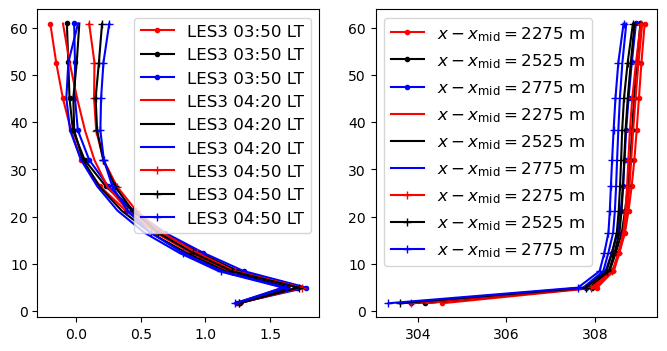

In [7]:
try:
    del(fig, axs)
    print("deleted old figure")
    fig, axs = plt.subplots( 1, 2, figsize=(8, 4) )
except:
    fig, axs = plt.subplots( 1, 2, figsize=(8, 4) )

ztop = 50 # [m a.s.l.]
ktop = 12 # just for speed, make sure higher than ztop everywhere

timestyle=['.-','-','+-']
loccolor= ['r','k','b']
timelabels=times.strftime('%H:%M')
loclabels=[str(int(xp-xmid)) for xp in xplot]

for it, itime in enumerate(itimes):
    for i, ix in enumerate(ixs):

        zc, zu = zgrid(ds, itime, ktop, ix)
        
        u_wrf = ds['U'][itime,:ktop,:,ix].mean(dim="south_north")
        T_wrf = ds['T'][itime,:ktop,:,ix-1:ix+1].mean(dim="south_north") + 300 #- Tref - lapse*( zc + (xplot[1]-xplot[i])*np.tan(slope) )
    
        axs[0].plot(u_wrf,zu,timestyle[it]+loccolor[i],label=path[-4:]+' '+timelabels[it]+' LT')
            
        # axs[1].plot(T_wrf[:,0],zc[:,0]) # slightly uphill
        axs[1].plot(T_wrf.mean(axis=1),zc.mean(axis=1), timestyle[it]+loccolor[i],
                    label=r'$x-x_{\text{mid}}=$'+loclabels[i]+' m')
        # axs[1].plot(T_wrf[:,1],zc[:,1]) # slightly downhill
axs[0].legend(fontsize=12)        
axs[1].legend(fontsize=12)

In [8]:
handles,labels=axs[0].get_legend_handles_labels()
axs[0].legend(ncol=1,handles=handles[1:9:3],
              labels=labels[1:9:3])
handles,labels=axs[1].get_legend_handles_labels()
axs[1].legend(ncol=1,handles=handles[3:6],
              labels=labels[3:6])

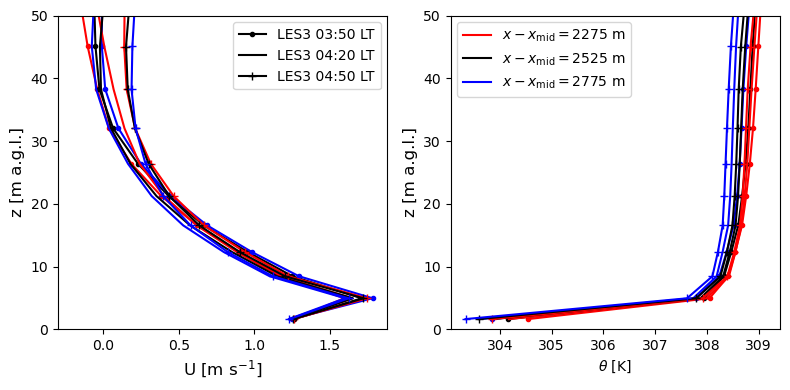

In [9]:
for ax in axs:
    ax.set_ylim( (0, ztop) )
axs[0].set_ylabel("z [m a.g.l.]",size=12)
axs[0].set_xlabel(r'U [m s$^{-1}$]',size=12)
axs[1].set_ylabel("z [m a.g.l.]",size=12)
# axs[1].set_xlabel(r"$\theta'$ [K]",size=12) 
axs[1].set_xlabel(r"$\theta$ [K]")  
fig.tight_layout() 
fig

In [10]:
if save:
    plt.figure(fig)
    fmts=["png","eps"]
    for fmt in fmts:
        plt.savefig("plots/"+savename+"."+fmt, format=fmt)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
